In [1]:
import networkx as nx 
from scipy.sparse import csr_matrix
import random
import numpy as np
#importing the matplotlib library for plotting the graph 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#matplotlib.use('Agg')
from scipy.io import loadmat
from numpy import linalg as LA
import scipy.io

In [2]:
nvex = 68
random.seed(123456)

net_data = []
response = []
nrep = 100
A_erdos = np.zeros([nvex,nvex])
A_small = np.zeros([nvex,nvex])
A_commu = np.zeros([nvex,nvex])
A_scale = np.zeros([nvex,nvex])
for i in range(nrep):
    ## Erdos network
    G = nx.gnm_random_graph(nvex,400, seed=123) 
    A = nx.adjacency_matrix(G)
    A = csr_matrix.todense(A)
    A_erdos = A_erdos + A
    net_data.append(A.reshape(nvex,nvex))
    ## Small world network
    G = nx.watts_strogatz_graph(nvex, 10, 0.5)
    A = nx.adjacency_matrix(G)
    A = csr_matrix.todense(A)
    A_small = A_small + A
    net_data.append(A.reshape(nvex,nvex))
    ## Random Community network
    G = nx.random_partition_graph([34, 34], .25,.01)
    A = nx.adjacency_matrix(G)
    A = csr_matrix.todense(A)
    A_commu = A_commu + A
    net_data.append(A.reshape(nvex, nvex))

In [3]:
alpha = np.zeros(68)
alpha[0:17]=1


net_data = []
label = []
nrep = 100
for i in range(nrep):
    A = np.random.binomial(1,0.8*A_erdos/nrep, A.shape)
    # A = np.matmul(A,A)
    net_data.append(A.reshape(nvex,nvex))
    label.append(0.0)
    A = np.random.binomial(1,A_small/nrep, A.shape)
    # A = np.matmul(A,A)
    net_data.append(A.reshape(nvex,nvex))
    label.append(1.0)
    A = np.random.binomial(1,A_commu/nrep, A.shape)
    # A = np.matmul(A,A)
    net_data.append(A.reshape(nvex,nvex))
    label.append(2.0)

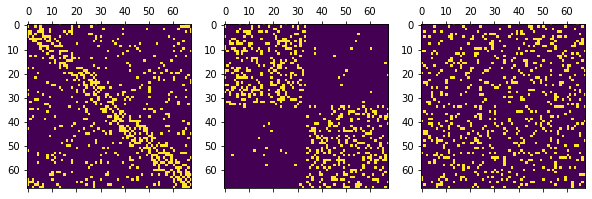

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.matshow(net_data[1])
ax2.matshow(net_data[2])
ax3.matshow(net_data[3])

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [6]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

In [7]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def transform1d(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.mu, feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})
    
        

In [8]:
def train_random_networks(network_architecture, 
                    learning_rate=0.001, batch_size=6, n_epoch=10):
    """
    Train the VAE model on the Brain Connectomes data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    train_data = np.stack(net_data).reshape(-1, 68*68) 
    train_size = train_data.shape[0]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [25]:
network_architecture = dict(n_hidden_enc_1 = 1000, 
                             n_hidden_enc_2 = 200, 
                             n_hidden_dec_1 = 200, 
                             n_hidden_dec_2 = 1000, 
                             n_input = 68 * 68, 
                             n_z = 2)  

vae_2d = train_random_networks(network_architecture, n_epoch = 20)

Epoch: 1/20 Loss = 1605.4971
Epoch: 2/20 Loss = 1295.1266
Epoch: 3/20 Loss = 1208.4739
Epoch: 4/20 Loss = 1172.7807
Epoch: 5/20 Loss = 1164.0685
Epoch: 6/20 Loss = 1153.8176
Epoch: 7/20 Loss = 1143.4887
Epoch: 8/20 Loss = 1138.3505
Epoch: 9/20 Loss = 1134.3170
Epoch: 10/20 Loss = 1133.0907
Epoch: 11/20 Loss = 1131.2529
Epoch: 12/20 Loss = 1130.1318
Epoch: 13/20 Loss = 1129.7020
Epoch: 14/20 Loss = 1128.7638
Epoch: 15/20 Loss = 1127.6210
Epoch: 16/20 Loss = 1126.4083
Epoch: 17/20 Loss = 1126.6061
Epoch: 18/20 Loss = 1126.3505
Epoch: 19/20 Loss = 1125.9288
Epoch: 20/20 Loss = 1125.5927


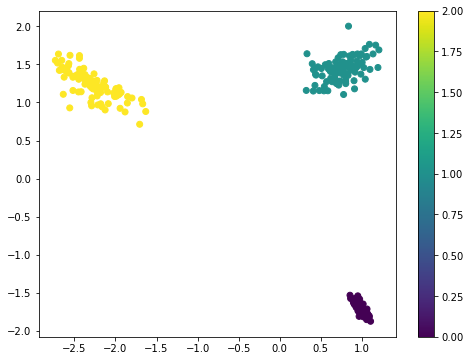

In [37]:
networks = np.stack(net_data).reshape(-1, 68*68)
labels = np.array(label)
z_mu = vae_2d.transform1d(networks)
plt.figure(figsize=(8, 6)) 
#plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample))
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=labels)
#plt.scatter(z_mu[:, 0], z_mu[:, 1])
plt.colorbar()
plt.grid(False)

In [9]:
network_architecture = dict(n_hidden_enc_1 = 1000, 
                             n_hidden_enc_2 = 200, 
                             n_hidden_dec_1 = 200, 
                             n_hidden_dec_2 = 1000, 
                             n_input = 68 * 68, 
                             n_z = 20)  

vae = train_random_networks(network_architecture, n_epoch = 20)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch: 1/20 Loss = 1501.3699
Epoch: 2/20 Loss = 1218.5106
Epoch: 3/20 Loss = 1202.4228
Epoch: 4/20 Loss = 1180.2343
Epoch: 5/20 Loss = 1166.7053
Epoch: 6/20 Loss = 1159.6895
Epoch: 7/20 Loss = 1154.8086
Epoch: 8/20 Loss = 1150.0951
Epoch: 9/20 Loss = 1145.3022
Epoch: 10/20 Loss = 1143.0076
Epoch: 11/20 Loss = 1139.7466
Epoch: 12/20 Loss = 1140.1603
Epoch: 13/20 Loss = 1139.0028
Epoch: 14/20 Loss = 1129.9147
Epoch: 15/20 Loss = 1128.0355
Epoch: 16/20 Loss = 1122.5442
Epoch: 17/20 Loss = 1118.2300
Epoch: 18/20 Loss = 1115.5813
Epoch: 19/20 Loss = 1107.8375
Epoch: 20/20 Loss = 1101.9464


In [11]:
networks = np.stack(net_data).reshape(-1, 68*68)
recon_networks = vae.reconstruct(networks[0:6,])

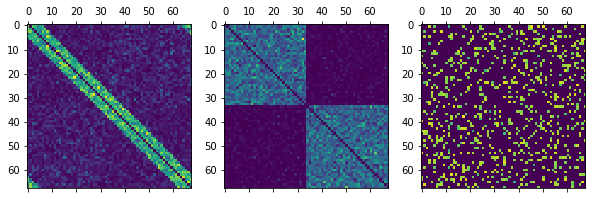

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.matshow(recon_networks[1].reshape(68, 68))
ax2.matshow(recon_networks[2].reshape(68, 68))
ax3.matshow(recon_networks[3].reshape(68, 68))